# This is the same pretraining notebook but on mel scale spectrograms

In [1]:
gpus = [0]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Load data

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [6]:
results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [7]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_mel_restricted.p')))[-1]

In [8]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [9]:
spec_df.tail()

,name,wav,spec
65891,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.93585175, -0.96087265, -0.95896244, -0.95..."
65892,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.9471635, -0.8315903, -0.8912175, -0.94100..."
65893,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71280247, -0.69285095, -0.62940675, -0.57..."
65894,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8336875, -0.8541795, -0.94698066, -0.7893..."
65895,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.54891306, -0.5926078, -0.6417409, -0.7170..."


In [10]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [11]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

186 76


In [12]:
spec_list = spec_df.spec.values.tolist()

In [13]:
subj_list = spec_df.name.values.tolist()

In [14]:
n_slices = (4, 1)

# This notebook is on only horizontal slices (spectral slices)

## Define model

In [15]:
clear_session()

## parse inputs and outputs

In [16]:
input_list = []
output_list = []

for spec in spec_list:
    slice_list, index_list = slice_matrix(spec, 
                                          n_slices=n_slices, 
                                          slice_shape=(45, 70))
    input_list.append(slice_list)
    output_list.append(index_list)

In [17]:
input_data = np.array(input_list)

In [18]:
input_data = np.transpose(input_data, (1, 0, 2, 3, 4))

In [19]:
input_data = list(input_data)

In [20]:
output_data = np.array(output_list)

In [21]:
output_data.shape

(65896, 4)

In [22]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_list, test_size = 0.1, 
                                                                      random_state=20)

In [23]:
n_train, _, h, w, _ = np.array(input_train).shape

In [24]:
print(n_train, h, w)

59306 45 70


In [25]:
model=self_VGG()

## connect dense layers and input/output

In [26]:
model_inputs = []
for i in range(np.product(n_slices)):
    model_inputs.append(Input(shape=(h, w, 3)))

In [27]:
encodings = []
for i in range(np.product(n_slices)):
    resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs[i])
    encodings.append(model(resized))
concated = layers.Concatenate(axis=1)(encodings)
dense = layers.Dense(4096)(concated)
model_output = layers.Dense(np.product(n_slices))(dense) # this needs to be changed for both temporal and spectral slices
cfn = Model(model_inputs, model_output)

In [28]:
cfn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45, 70, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 45, 70, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 45, 70, 3)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 45, 70, 3)]  0                                            
_______________________________________________________________________________________

In [29]:
cfn.compile(loss='mse', optimizer = Adam(0.000001)) # need to figure out how to implement FY loss

## train the model to sort spectral slices order

In [30]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()))
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model trained on spectral slicing of Starling songs in mel scale (restricted to morph stim size), 4 slices')

In [31]:
patience = 20
batch_size = 32
epochs = 1000

In [32]:
model_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
            ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]

cfn.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 59306 samples, validate on 6590 samples
Epoch 1/1000
10432/59306 [====>.........................] - ETA: 22:52 - loss: 2.0708

KeyboardInterrupt: 

In [37]:
pickle.dump([input_data, output_data], open(os.path.join(run_folder, 'train_data.p'), 'wb'))

KeyboardInterrupt: 

In [38]:
cfn.load_weights(model_file)

In [39]:
input_test = np.array(input_test)

In [40]:
print(input_test.shape)

(6590, 4, 45, 70, 3)


In [41]:
input_test = list(input_test.transpose((1,0,2,3,4)))

In [42]:
prediction_test = cfn.predict(input_test)

In [43]:
prediction_test[0]

array([ 1.9870799e+00,  3.0036125e+00,  9.9733853e-01, -2.5305967e-03],
      dtype=float32)

## prediction error (rmse)

In [44]:
print(np.sqrt(np.mean(np.square(prediction_test-output_test))))

0.03201359541651461


In [189]:
del cfn

In [45]:
prediction_test_int = np.round(prediction_test)

In [46]:
print(prediction_test_int[1])

[ 2. -0.  3.  1.]


In [47]:
print(np.mean(prediction_test_int==output_test))

0.9999241274658573


# fine tune on stim classification

Groups:
1. ABCD vs EFGH
2. ABGH vs EFCD
3. ABEF vs CDGH

### Load the morph dataset

In [15]:
morph_file =  os.path.join(os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli/'), 'spec_mel_restricted.p')
morph_df = pickle.load(open(morph_file, 'rb'))
morph_df.tail()

,stim,id,wav,spec
3067,fh,124,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5515226, -0.58929485, -0.6610836, -0.5626..."
3068,fh,125,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.57625896, -0.60393876, -0.573943, -0.6204..."
3069,fh,126,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5687164, -0.5868779, -0.5843344, -0.59702..."
3070,fh,127,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.36883134, -0.49406675, -0.6150616, -0.645..."
3071,fh,128,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.502964, -0.5549107, -0.61619097, -0.66653..."


### First we make sure AE1 and AG1 are the same thing

In [16]:
morph_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23444802, -0.32770982, -0.4576597, -0.440..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.19216497, -0.3240278, -0.4519775, -0.4527..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.22530042, -0.2954273, -0.45014453, -0.464..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23662604, -0.3088082, -0.45463002, -0.488..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.27267733, -0.33855087, -0.4580862, -0.497..."


In [35]:
AE1 = morph_df[(morph_df['stim']=='ae') & (morph_df['id']==1)].spec.tolist()[0]

In [36]:
AF1 = morph_df[(morph_df['stim']=='af') & (morph_df['id']==1)].spec.tolist()[0]

In [37]:
AC1 = morph_df[(morph_df['stim']=='ac') & (morph_df['id']==1)].spec.tolist()[0]

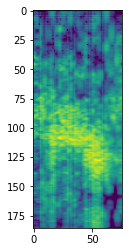

In [38]:
plt.imshow(AE1)

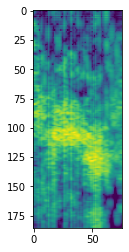

In [39]:
plt.imshow(AF1)

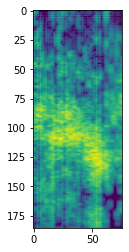

In [40]:
plt.imshow(AC1)

In [18]:
AC128 = morph_df[(morph_df['stim']=='ac') & (morph_df['id']==128)].spec.tolist()[0]

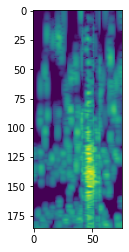

In [19]:
plt.imshow(AC128)

It seems the specific numbers of each specgram might be different but the image refers to the same stim

# Let's show all specgram combinations

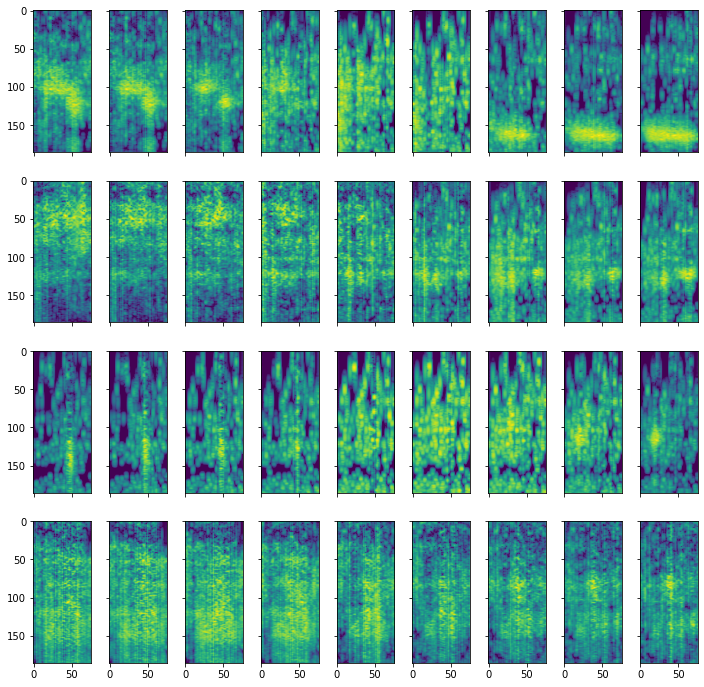

In [21]:
fig, ax = plt.subplots(4, 9, figsize=(12, 12), sharex=True, sharey=True)
row = 0
col = 0
for combo in ['ae', 'bf', 'cg', 'dh']:
    for i in [1]+list(range(16, 144, 16)):
        spec_i = morph_df[(morph_df['stim']==combo) & (morph_df['id']==i)].spec.tolist()[0]
        ax[row][col].imshow(spec_i)
        col+=1
    row+=1
    col = 0

## 1. ABCD vs EFGH

### make inputs and outputs

In [67]:
morph_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23444802, -0.32770982, -0.4576597, -0.440..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.19216497, -0.3240278, -0.4519775, -0.4527..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.22530042, -0.2954273, -0.45014453, -0.464..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23662604, -0.3088082, -0.45463002, -0.488..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.27267733, -0.33855087, -0.4580862, -0.497..."


In [68]:
left_stims = 'abcd'
right_stims = 'efgh'

In [69]:
# training data
input_list = []
output_list = []
for L, R in itertools.product(left_stims, right_stims):
    L_stim = morph_df[(morph_df['stim']==(L+R)) & (morph_df['id']==1)].spec.tolist()[0]
    input_list.append(np.stack([L_stim]*3, axis=2))
    output_list.append([1, 0])
    R_stim = morph_df[(morph_df['stim']==(L+R)) & (morph_df['id']==128)].spec.tolist()[0]
    input_list.append(np.stack([R_stim]*3, axis=2))
    output_list.append([0, 1])

In [70]:
# validation data
validation_inputs = []
validation_outputs = []
for L, R in itertools.product(left_stims, right_stims):
    L_stim = morph_df[(morph_df['stim']==(L+R)) & (morph_df['id']==2)].spec.tolist()[0]
    validation_inputs.append(np.stack([L_stim]*3, axis=2))
    validation_outputs.append([1, 0])
    R_stim = morph_df[(morph_df['stim']==(L+R)) & (morph_df['id']==127)].spec.tolist()[0]
    validation_inputs.append(np.stack([R_stim]*3, axis=2))
    validation_outputs.append([0, 1])
validation_inputs = np.array(validation_inputs)
validation_outputs = np.array(validation_outputs)

In [71]:
np.unique(output_list, return_counts=True, axis=0)

(array([[0, 1],
        [1, 0]]),
 array([16, 16]))

In [72]:
input_data = np.array(input_list)
output_data = np.array(output_list)

In [73]:
n_samples, n_outputs=output_data.shape

In [74]:
h, w = input_data[0].shape[:2]
print(n_samples, n_outputs, h, w)

32 2 186 76


### make model

In [84]:
clear_session()

In [85]:
model=self_VGG()

In [86]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) 
classifier = Model(model_inputs, model_output)

In [87]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 186, 76, 3)]      0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [88]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/weights-improvement.h5'),
                       by_name=True)

In [89]:
classifier.compile(loss='binary_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [90]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2022_03_29_21_29_10', 'Group1')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on short segments of starling motifs in star scale, \
               fine tuned on stim classification Group 1(ABCD vs EFGH)')

In [91]:
patience = 20
batch_size = 10
epochs = 1000

In [92]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_data=(validation_inputs, validation_outputs))

Train on 32 samples, validate on 32 samples
Epoch 1/1000
32/32 [==============================] - 8s 255ms/sample - loss: 0.6854 - accuracy: 0.5625 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 3/1000
32/32 [==============================] - 5s 159ms/sample - loss: 0.6942 - accuracy: 0.4375 - val_loss: 0.6900 - val_accuracy: 0.5312
Epoch 4/1000
32/32 [==============================] - 6s 181ms/sample - loss: 0.6865 - accuracy: 0.5625 - val_loss: 0.6897 - val_accuracy: 0.7500
Epoch 5/1000
32/32 [==============================] - 0s 12ms/sample - loss: 0.6872 - accuracy: 0.6562 - val_loss: 0.6881 - val_accuracy: 0.7188
Epoch 6/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6869 - accuracy: 0.6250 - val_loss: 0.6859 - val_accuracy: 0.6562
Epoch 7/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6827

## 2. ABGH vs CDEF

### make inputs and outputs

In [93]:
morph_df.tail()

,stim,id,wav,spec
3067,fh,124,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5515226, -0.58929485, -0.6610836, -0.5626..."
3068,fh,125,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.57625896, -0.60393876, -0.573943, -0.6204..."
3069,fh,126,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5687164, -0.5868779, -0.5843344, -0.59702..."
3070,fh,127,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.36883134, -0.49406675, -0.6150616, -0.645..."
3071,fh,128,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.502964, -0.5549107, -0.61619097, -0.66653..."


In [94]:
morph_df[(morph_df['stim']=='ad') & (morph_df['id']==1)]

,stim,id,wav,spec
128,ad,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.47095948, -0.5192277, -0.62177515, -0.614..."


In [95]:
left_stims = 'abgh'
right_stims = 'cdef'

In [96]:
# training data
input_list = []
output_list = []
for L, R in itertools.product(left_stims, right_stims):
#     print(L, R)
    L_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==1)].spec.tolist()[0]
    input_list.append(np.stack([L_stim]*3, axis=2))
    output_list.append([1, 0])
    R_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==128)].spec.tolist()[0]
    input_list.append(np.stack([R_stim]*3, axis=2))
    output_list.append([0, 1])

In [97]:
# validation data
validation_inputs = []
validation_outputs = []
for L, R in itertools.product(left_stims, right_stims):
    L_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==2)].spec.tolist()[0]
    validation_inputs.append(np.stack([L_stim]*3, axis=2))
    validation_outputs.append([1, 0])
    R_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==127)].spec.tolist()[0]
    validation_inputs.append(np.stack([R_stim]*3, axis=2))
    validation_outputs.append([0, 1])
validation_inputs = np.array(validation_inputs)
validation_outputs = np.array(validation_outputs)

In [98]:
np.unique(output_list, return_counts=True, axis=0)

(array([[0, 1],
        [1, 0]]),
 array([16, 16]))

In [99]:
input_data = np.array(input_list)
output_data = np.array(output_list)

In [100]:
n_samples, n_outputs=output_data.shape

In [101]:
h, w = input_data[0].shape[:2]
print(n_samples, n_outputs, h, w)

32 2 186 76


### make model

In [102]:
clear_session()

In [103]:
model=self_VGG()

In [104]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) 
classifier = Model(model_inputs, model_output)

In [105]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 186, 76, 3)]      0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [106]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/weights-improvement.h5'),
                       by_name=True)

In [107]:
classifier.compile(loss='binary_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [108]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2022_03_29_21_29_10', 'Group2')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on short segments of starling motifs in star scale, \
               fine tuned on stim classification Group 2(ABGH vs CDEF)')

In [113]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_data=(validation_inputs, validation_outputs))

Train on 32 samples, validate on 32 samples
Epoch 1/1000
32/32 [==============================] - 4s 128ms/sample - loss: 0.6833 - accuracy: 0.5000 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 2/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 3/1000
32/32 [==============================] - 0s 12ms/sample - loss: 0.6877 - accuracy: 0.5000 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 4/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6799 - accuracy: 0.5000 - val_loss: 0.6782 - val_accuracy: 0.5000
Epoch 5/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6678 - accuracy: 0.5312 - val_loss: 0.6800 - val_accuracy: 0.5000
Epoch 6/1000
32/32 [==============================] - 0s 12ms/sample - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 7/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6871 -

## 3. ABEF vs CDGH

### make inputs and outputs

In [114]:
morph_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23444802, -0.32770982, -0.4576597, -0.440..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.19216497, -0.3240278, -0.4519775, -0.4527..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.22530042, -0.2954273, -0.45014453, -0.464..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23662604, -0.3088082, -0.45463002, -0.488..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.27267733, -0.33855087, -0.4580862, -0.497..."


In [115]:
left_stims = 'abef'
right_stims = 'cdgh'

In [116]:
# training data
input_list = []
output_list = []
for L, R in itertools.product(left_stims, right_stims):
#     print(L, R)
    L_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==1)].spec.tolist()[0]
    input_list.append(np.stack([L_stim]*3, axis=2))
    output_list.append([1, 0])
    R_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==128)].spec.tolist()[0]
    input_list.append(np.stack([R_stim]*3, axis=2))
    output_list.append([0, 1])

In [117]:
# validation data
validation_inputs = []
validation_outputs = []
for L, R in itertools.product(left_stims, right_stims):
    L_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==2)].spec.tolist()[0]
    validation_inputs.append(np.stack([L_stim]*3, axis=2))
    validation_outputs.append([1, 0])
    R_stim = morph_df[(morph_df['stim'].isin([L+R, R+L])) & (morph_df['id']==127)].spec.tolist()[0]
    validation_inputs.append(np.stack([R_stim]*3, axis=2))
    validation_outputs.append([0, 1])
validation_inputs = np.array(validation_inputs)
validation_outputs = np.array(validation_outputs)

In [118]:
np.unique(output_list, return_counts=True, axis=0)

(array([[0, 1],
        [1, 0]]),
 array([16, 16]))

In [119]:
input_data = np.array(input_list)
output_data = np.array(output_list)

In [120]:
n_samples, n_outputs=output_data.shape

In [121]:
h, w = input_data[0].shape[:2]
print(n_samples, n_outputs, h, w)

32 2 186 76


### make model

In [122]:
clear_session()

In [123]:
model=self_VGG()

In [124]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) 
classifier = Model(model_inputs, model_output)

In [125]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 186, 76, 3)]      0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [126]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/weights-improvement.h5'),
                       by_name=True)

In [127]:
classifier.compile(loss='binary_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [128]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2022_03_29_21_29_10', 'Group3')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on short segments of starling motifs in star scale, \
               fine tuned on stim classification Group 3(ABEF vs CDGH)')

In [130]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_data=(validation_inputs, validation_outputs))

Train on 32 samples, validate on 32 samples
Epoch 1/1000
32/32 [==============================] - 5s 148ms/sample - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/1000
32/32 [==============================] - 0s 12ms/sample - loss: 0.7025 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.7006 - accuracy: 0.4688 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 4/1000
32/32 [==============================] - 0s 12ms/sample - loss: 0.6992 - accuracy: 0.5000 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 5/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.7001 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 7/1000
32/32 [==============================] - 0s 12ms/sample - loss: 0.6909 -

Epoch 57/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.6376 - accuracy: 0.6875 - val_loss: 0.6188 - val_accuracy: 0.6562
Epoch 58/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.5985 - accuracy: 0.6875 - val_loss: 0.6021 - val_accuracy: 0.7500
Epoch 59/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.5940 - accuracy: 0.7812 - val_loss: 0.5962 - val_accuracy: 0.7500
Epoch 60/1000
32/32 [==============================] - 0s 11ms/sample - loss: 0.5458 - accuracy: 0.7500 - val_loss: 0.5942 - val_accuracy: 0.7500
Epoch 00060: early stopping
